Pass Initial Test, Moving on to Loading Session...

Processing: x=0, y=recording1, exp=experiment1, yy=recording1

EXPERIMENT1, Recording 1
Open Ephys GUI Recording
ID: 0x16a123aeb10
Format: Binary
Directory: HRPilot-05_FirstChronicTest1_2025-08-27_17-17-00_001\Record Node 106\experiment1\recording1
Experiment Index: 0
Recording Index: 0
Processor ID: 100, Stream Name: Rhythm Data, Line: 1 (main sync line))
  First event sample number: 288269
  Last event sample number: 7826703
  Total sync events: 230
  Sample rate: 6250.0
Channels: ['CH1', 'CH5', 'CH7', 'CH11', 'ADC1'] 

Loaded 297 MessageCenter entries
[Time: 40.261920 s] Message: Starting at 0.01 mA
[Time: 45.313760 s] Message: Starting at 0.01 mA
[Time: 46.109760 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 48.130560 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 49.998240 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 51.774080 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 53.580480 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 60

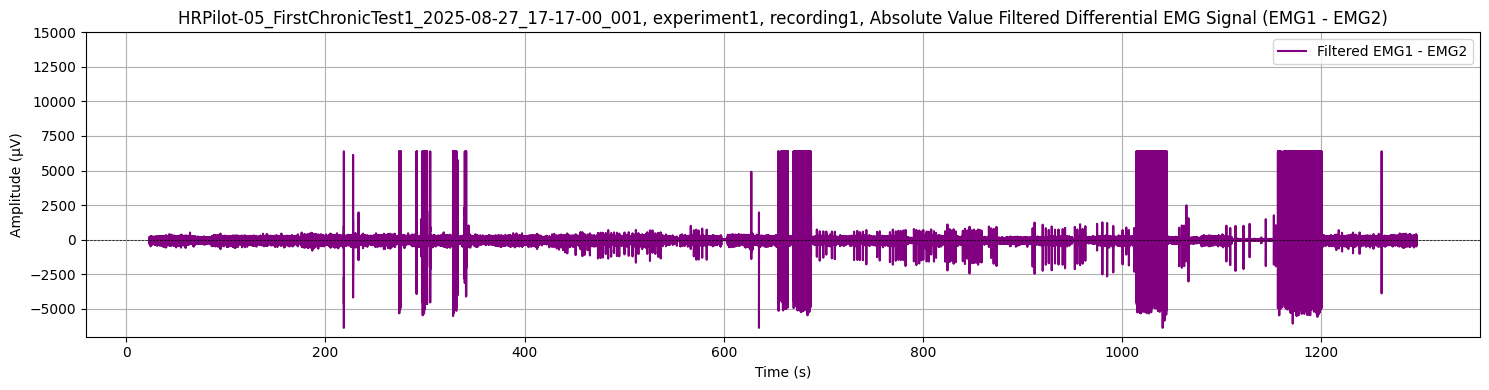

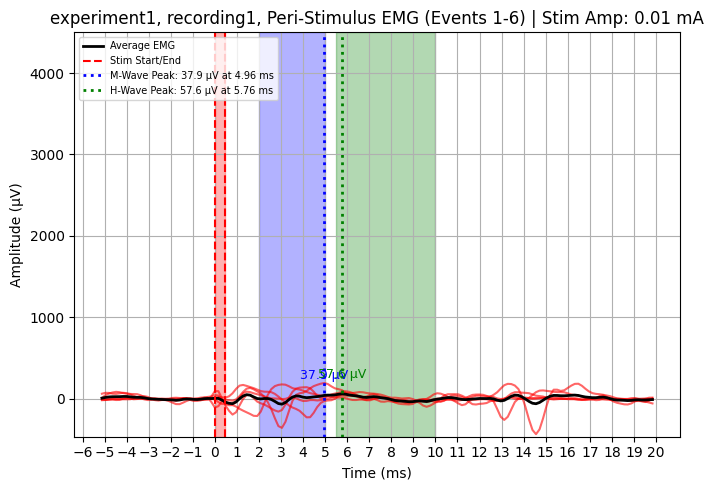

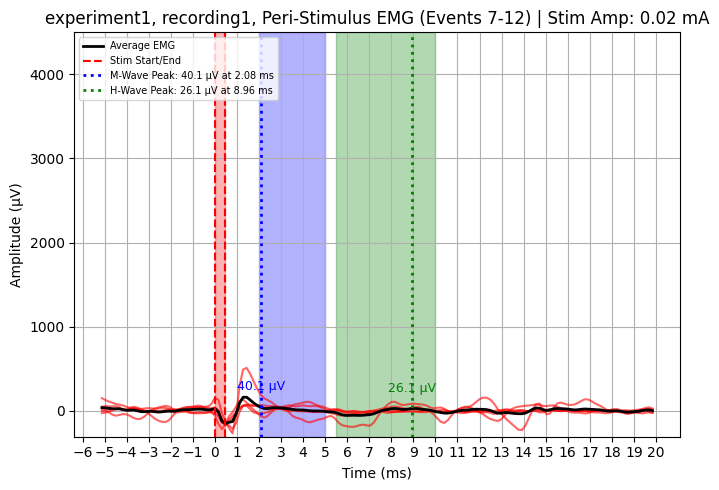

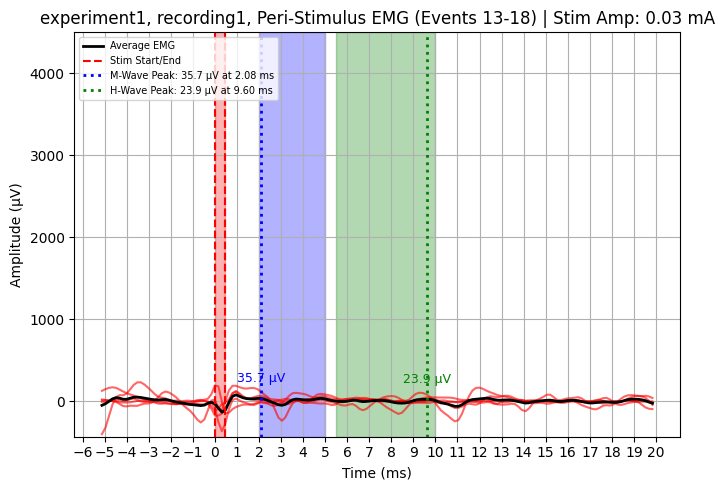

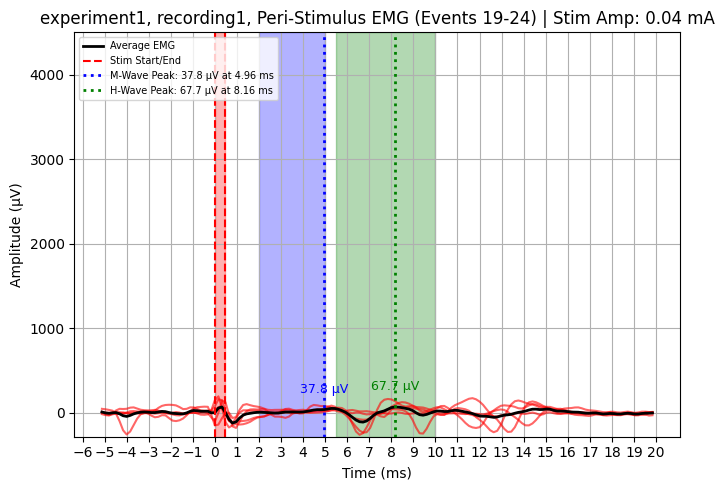

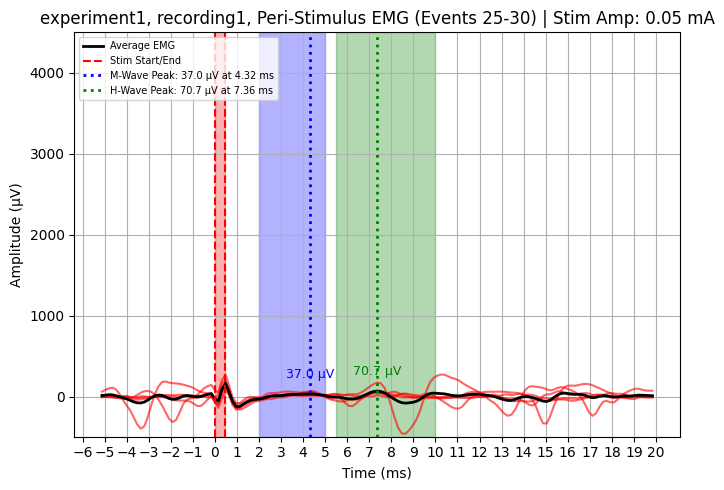

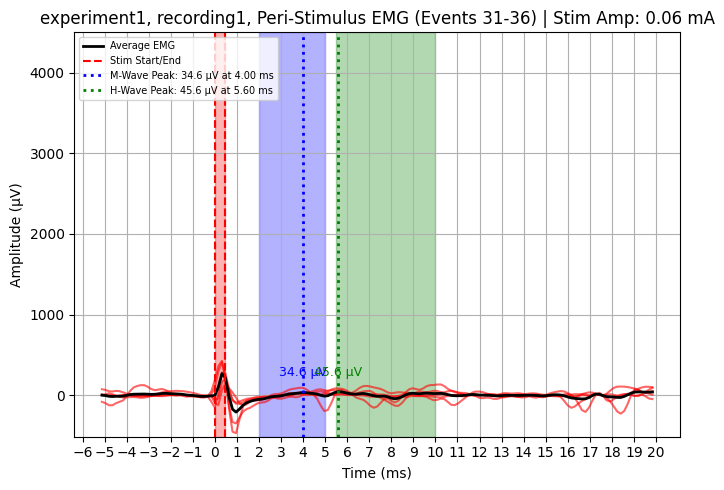

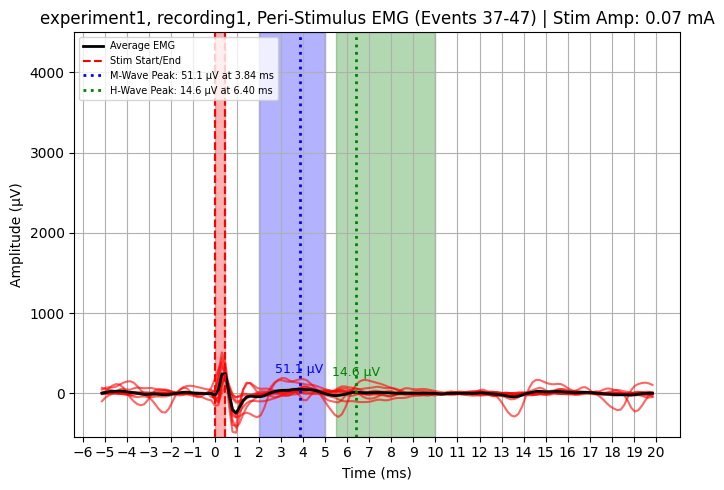

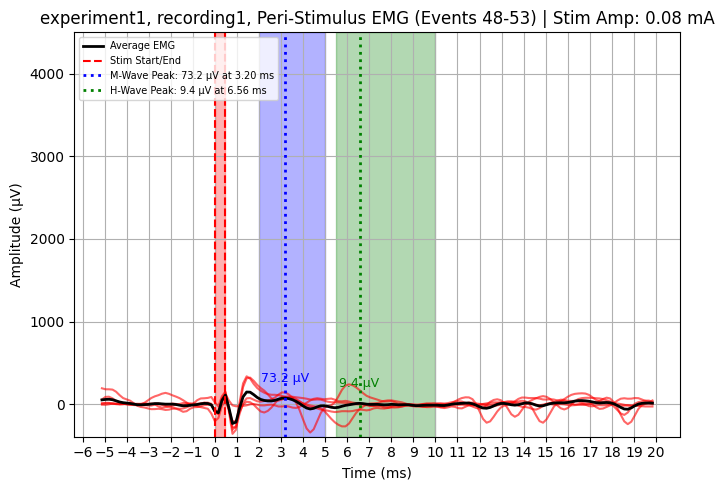

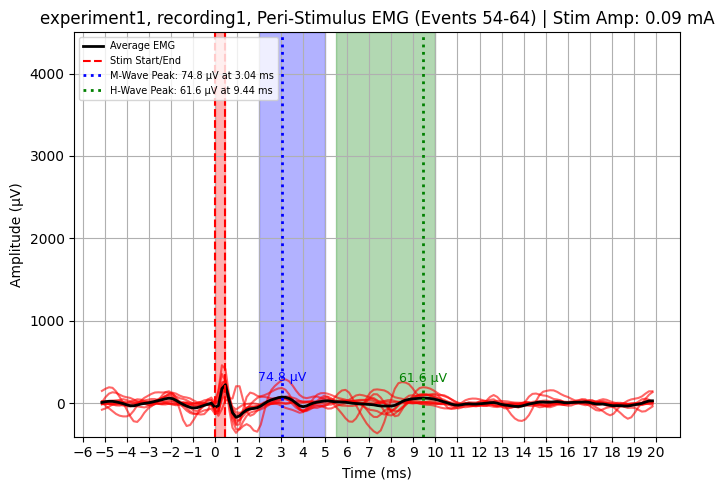

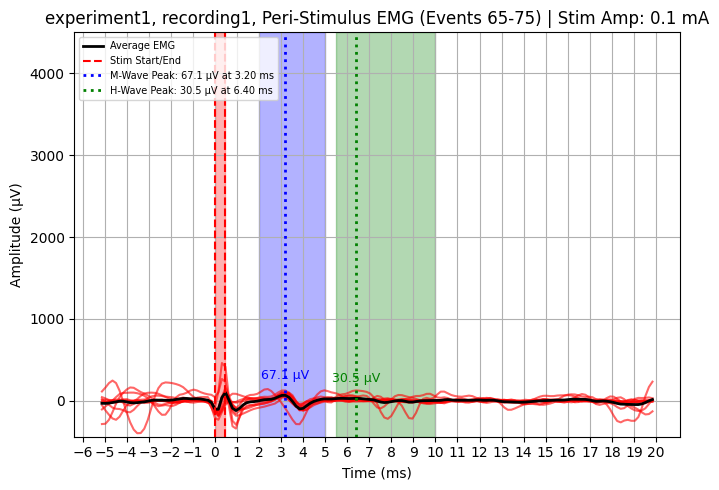

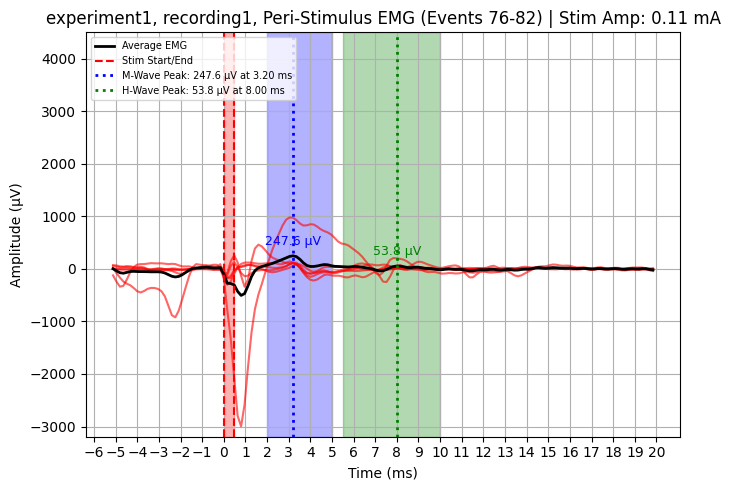

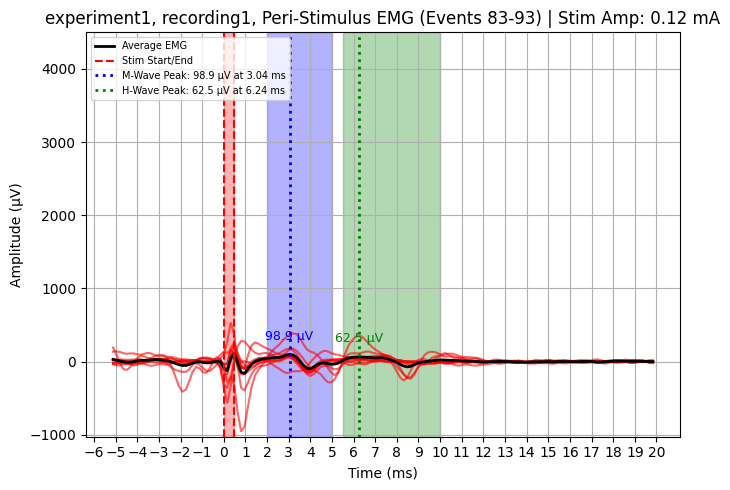

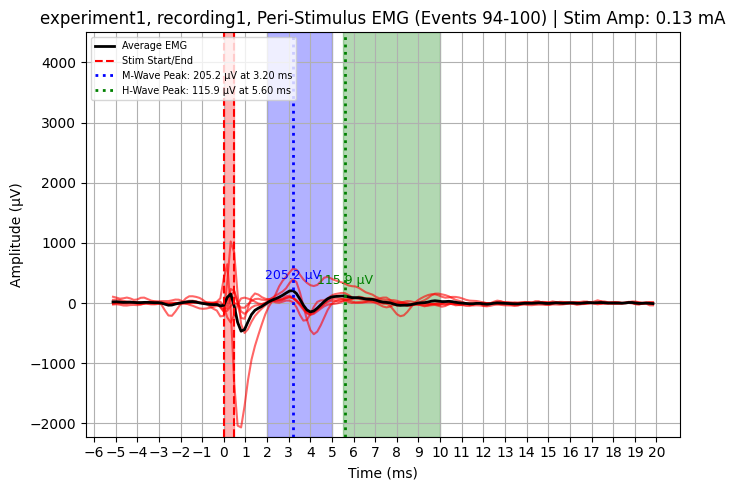

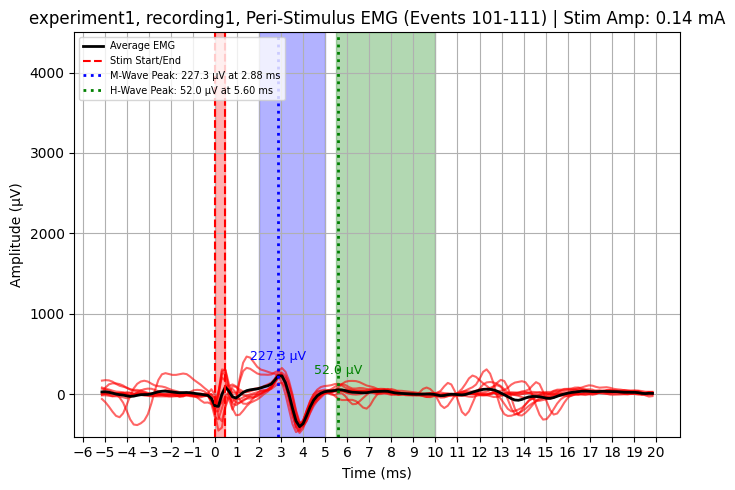

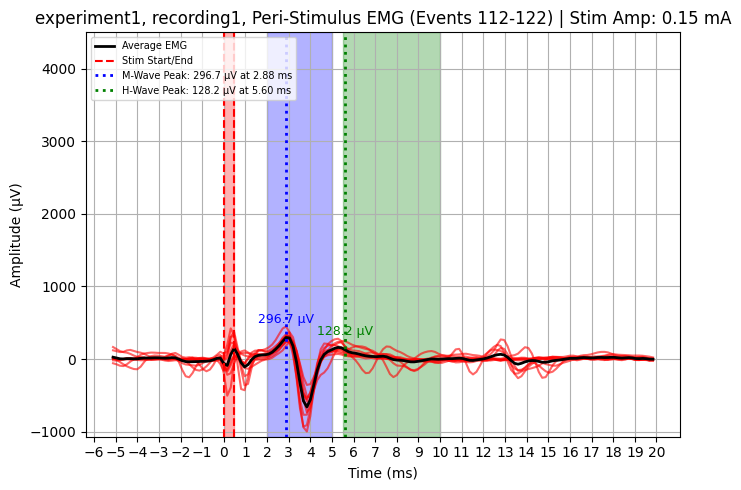

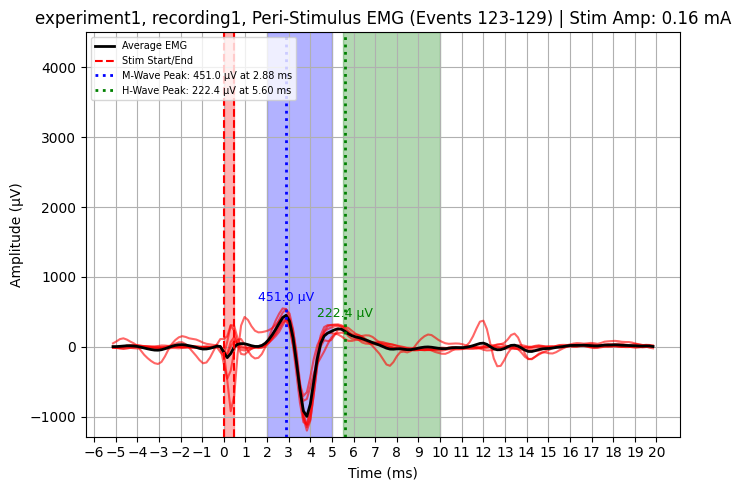

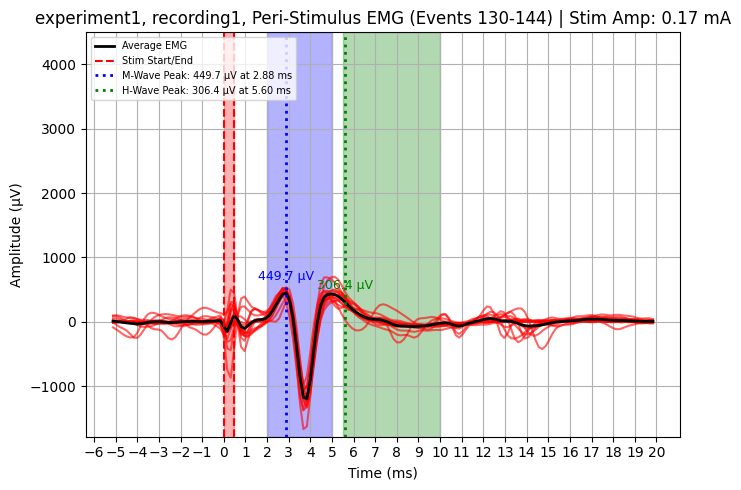

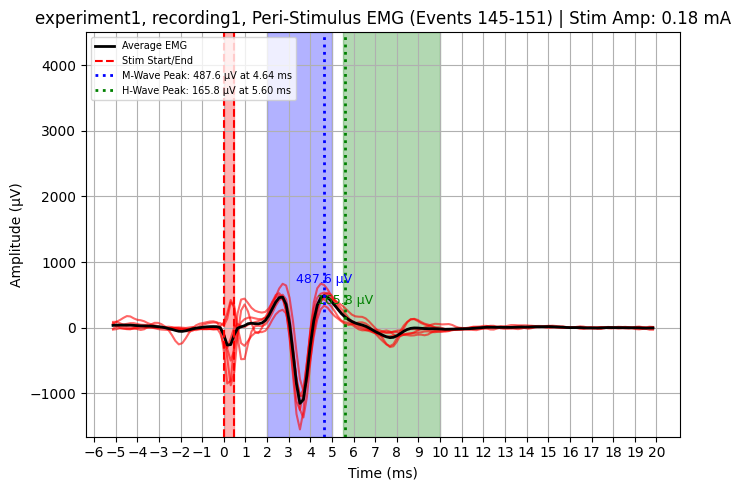

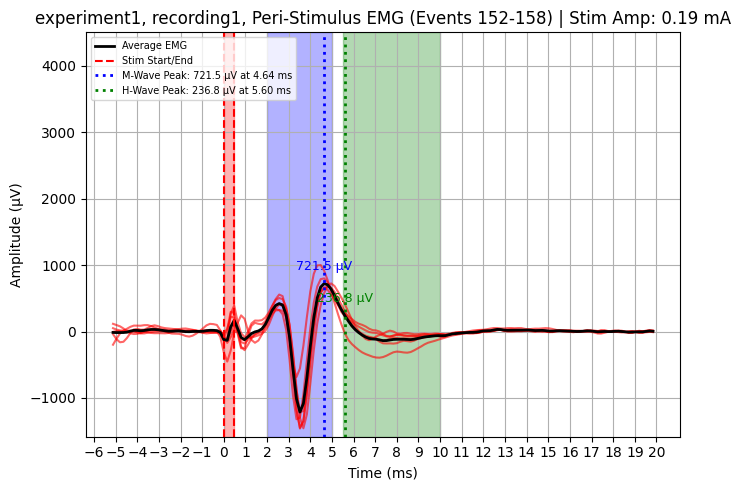

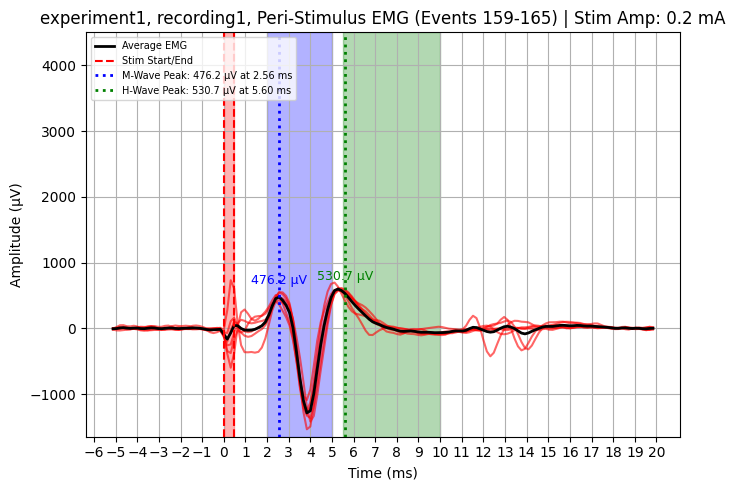

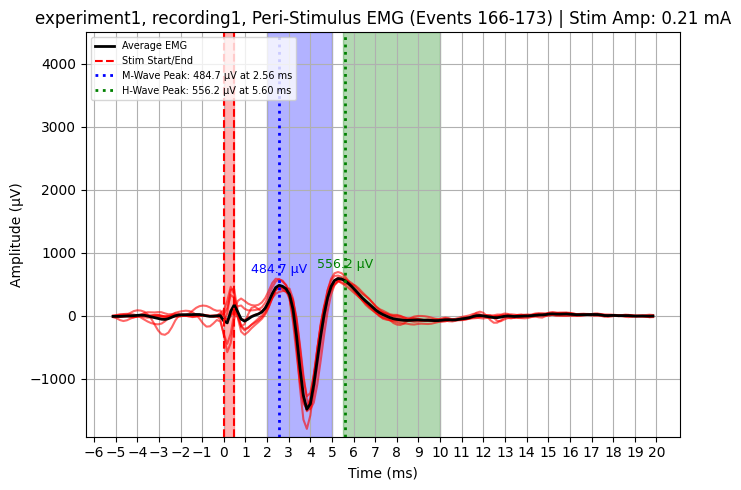

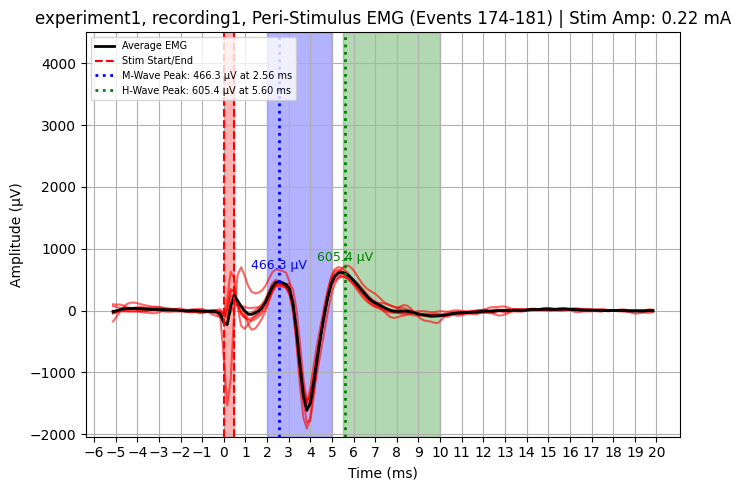

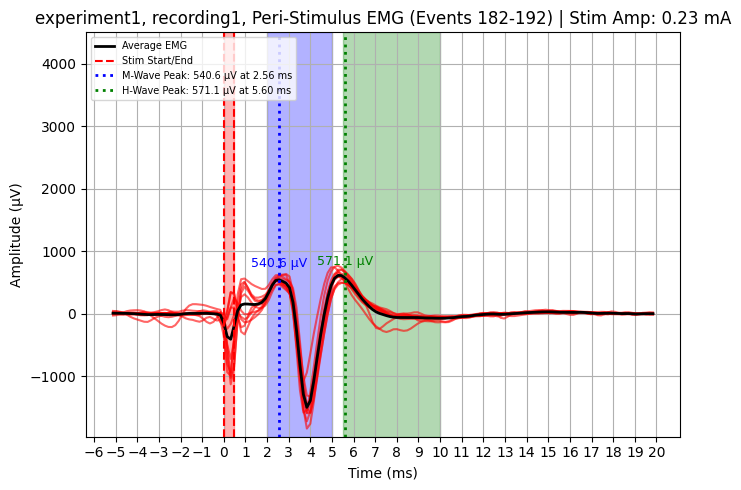

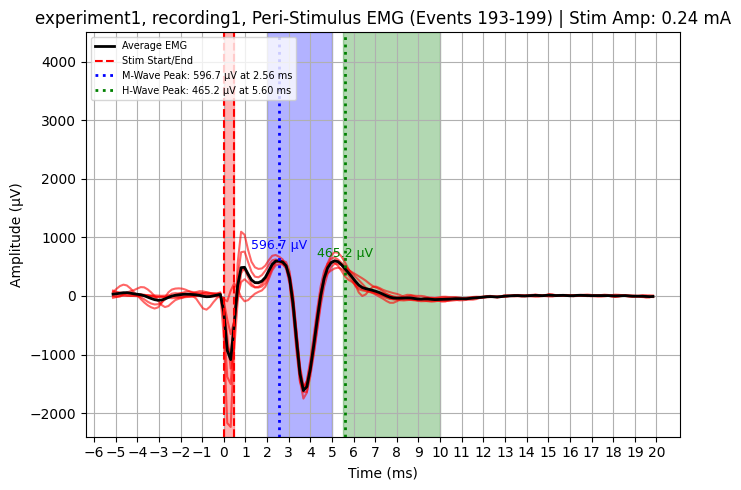

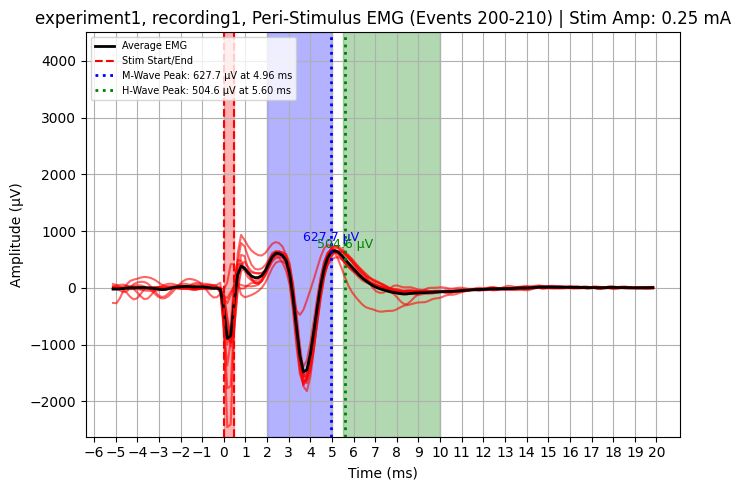

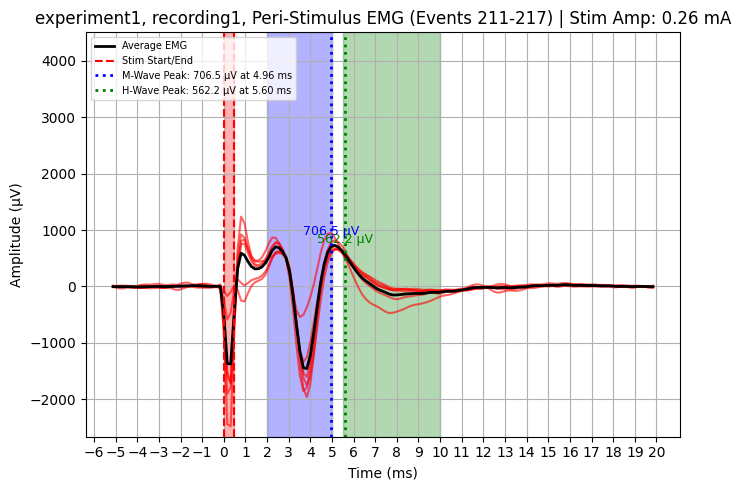

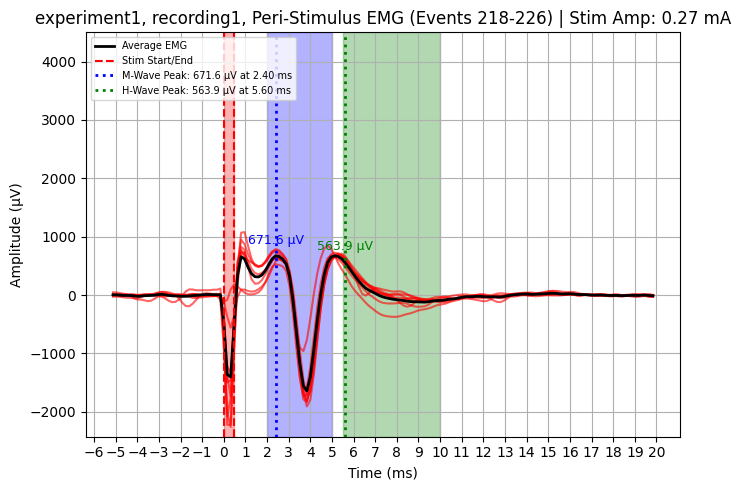

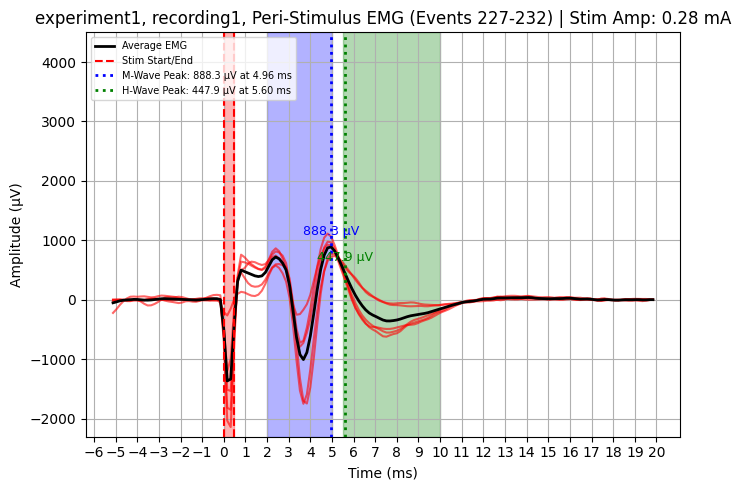

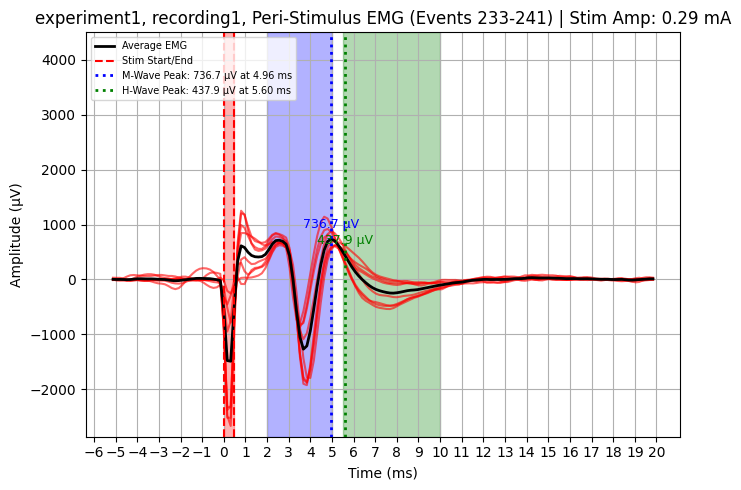

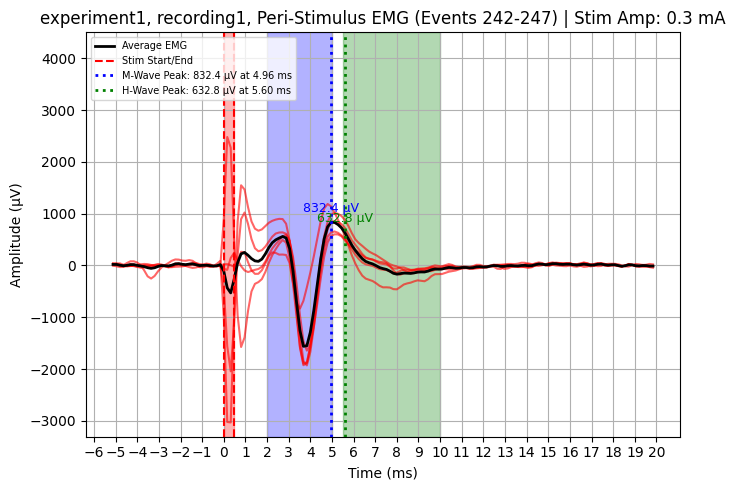

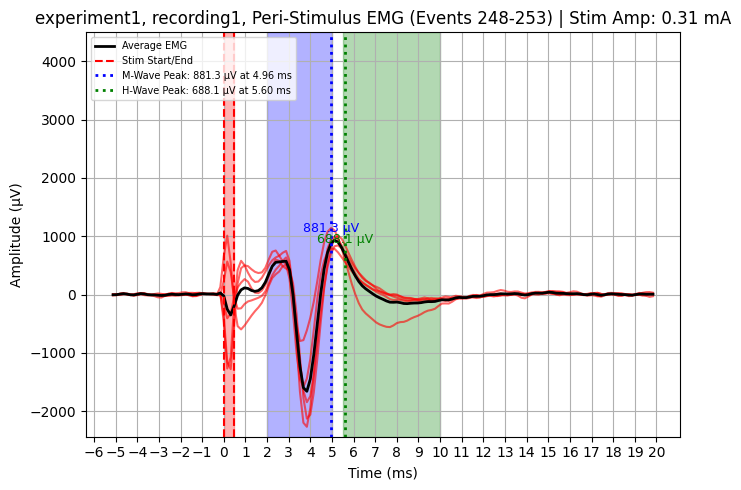

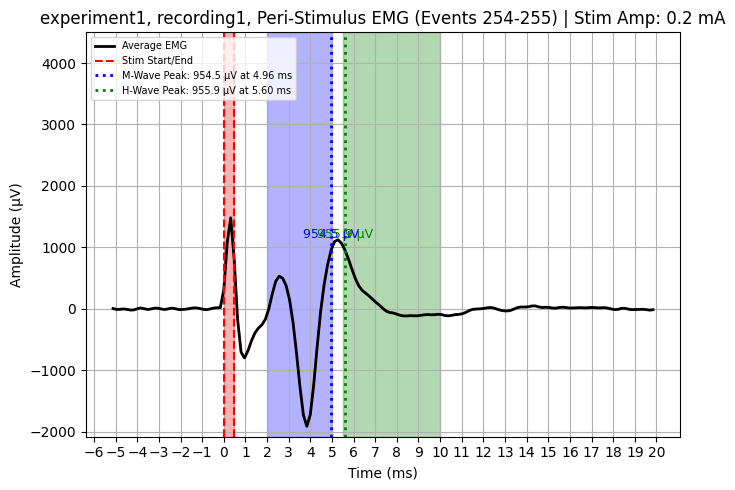

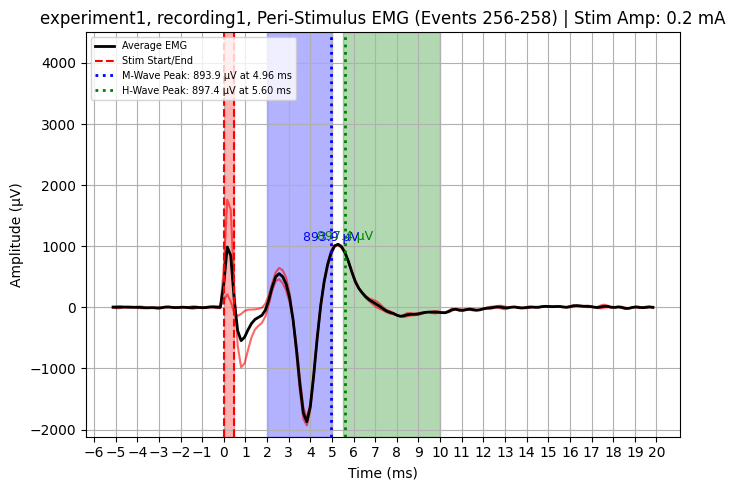

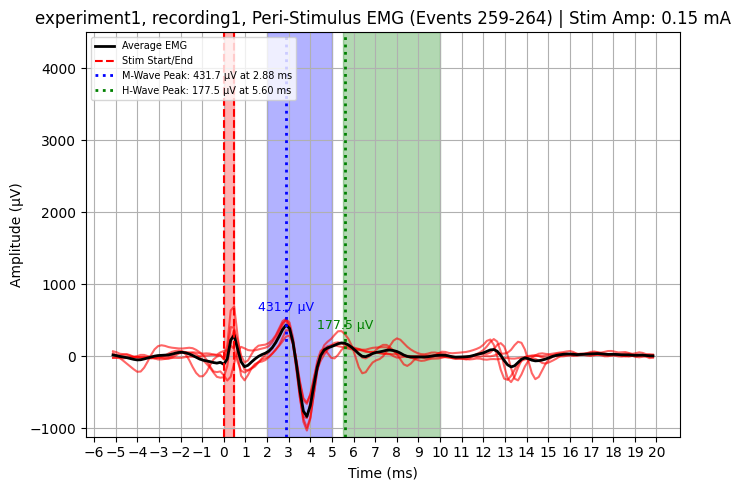

C:\Users\dal866445\AppData\Local\Temp\ipykernel_26764\1269063742.py:491: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  m_sems  = [stats.sem(peaks) for peaks in m_wave_data]
C:\Users\dal866445\AppData\Local\Temp\ipykernel_26764\1269063742.py:493: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_sems  = [stats.sem(peaks) for peaks in h_wave_data]


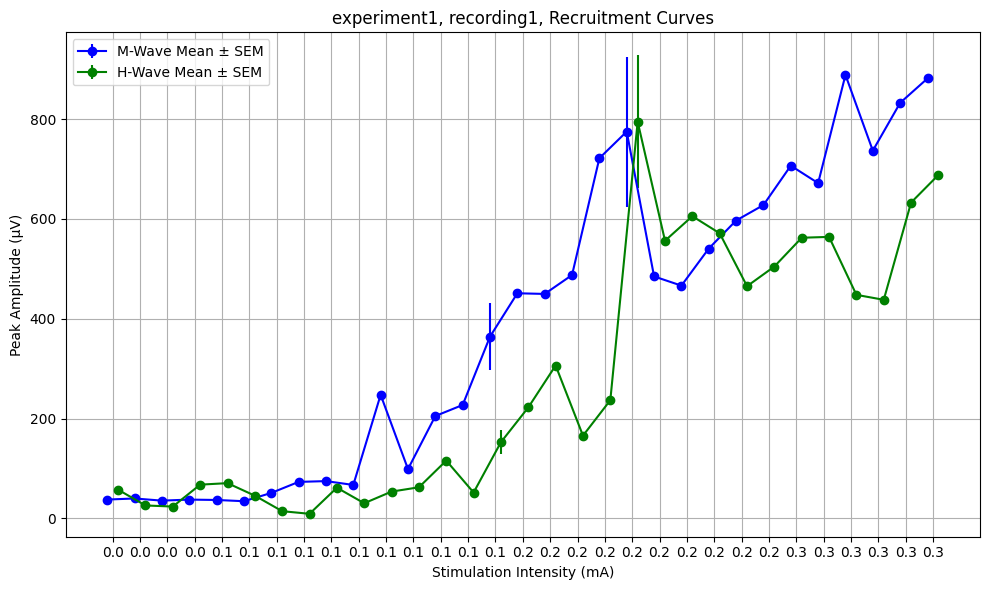

C:\Users\dal866445\AppData\Local\Temp\ipykernel_26764\1269063742.py:541: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  m_sems  = np.array([stats.sem(peaks) for peaks in m_wave_data])
C:\Users\dal866445\AppData\Local\Temp\ipykernel_26764\1269063742.py:542: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_sems  = np.array([stats.sem(peaks) for peaks in h_wave_data])


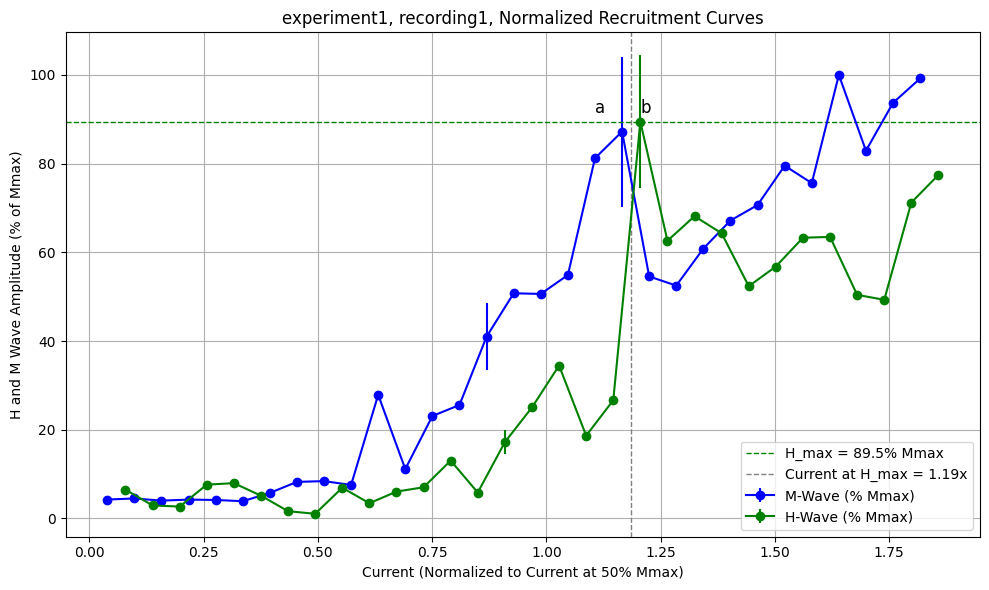

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from open_ephys.analysis import Session
import os
import re
from scipy.signal import butter, filtfilt, lfilter
from collections import defaultdict
import scipy.stats as stats


# ==== Select Session ====
w = 0  # recordnode index 1 = Record Node 111 RAW is Offline Filtered
u = 0       # recordnode index 0 = Record Node 106 is Online Filtered


m_wave_start, m_wave_end = 2, 5
h_wave_start, h_wave_end = 5.5, 10


def scan_experiment_structure(session_dir, record_node_name="Record Node 106"):
    node_path = os.path.join(session_dir, record_node_name)
    
    if not os.path.exists(node_path):
        print(f"Record Node directory not found: {node_path}")
        return {}
    
    experiment_info = defaultdict(list)
    for item in sorted(os.listdir(node_path)):
        exp_path = os.path.join(node_path, item)
        if os.path.isdir(exp_path) and item.startswith("experiment"):
            recordings = [r for r in sorted(os.listdir(exp_path)) 
                          if os.path.isdir(os.path.join(exp_path, r)) and r.startswith("recording")]
            experiment_info[item] = recordings
    return experiment_info

# ==== Load Session ====
#directory = 'SAP-55_2025-06-09_11-12-19_001'
#directory = 'SNARE-31_2025-07-22_17-09-49_002'

#directory = 'SNARE-38_2025-07-24_13-43-28_002'

#directory = 'SNARE-38-TEST2_2025-07-24_15-59-14_001'
#directory = 'SNARE-38-TEST3_2025-07-24_16-05-17_002'
#directory = 'SEQ-05_TEST12025-08-06_15-38-15_001'



#directory = 'SEQ-06/SEQ-6_TEST2025-08-13_13-12-10_001'
#directory = 'SEQ-06/SEQ-6_TRAIN2025-08-13_15-57-16_002'

#directory = 'SEQ-06/SEQ-6_TRAIN2_2025-08-13_16-52-15_003'

#directory = 'REG-03/REG-03-RAMP2_2025-08-19_17-53-12_002'
#directory = 'REG-03/REG-03-TRAIN_2025-08-19_19-07-25_003'

#directory = 'HRPilot-05_FirstChronicTest1_2025-08-27_17-17-00_001'
directory = 'HRPilot-05_FirstChronicTest1_2025-08-27_17-17-00_001'


session = Session(directory)
print('Pass Initial Test, Moving on to Loading Session...\n')

# === Scan structure ===
record_node_name = "Record Node 106" if w == 0 else "Record Node 111"
structure = scan_experiment_structure(directory, record_node_name)
#record_node_name_offline = "Record Node 111" if u == 0 else "Record Node 106"
#structure_offline = scan_experiment_structure(directory, record_node_name_offline)

# === Flatten experiment-recording pairs to loop ===
flat_recordings = []
for exp_name, rec_list in structure.items():
    for rec in rec_list:
        flat_recordings.append((exp_name, rec))

# === Iterate over recordings with x, y, yy convention ===
for x, (exp, yy) in enumerate(flat_recordings):
    y = f"recording{x + 1}"  # sequential label used in some parts of your code
    v = f"Record Node 106" if w == 0 else f"Record Node 111"
    vv = f"Record Node 111" if u == 0 else f"Record Node 106"
    i = 1

    try:
        recording = session.recordnodes[w].recordings[x]
        #recording_offline = session.recordnodes[w].recordings[x]
    except IndexError:
        print(f"No recording {x+1} found in {exp}/{yy}")
        continue

    print(f"Processing: x={x}, y={y}, exp={exp}, yy={yy}")

    # ==== Sync Setup ====
    print(f"\n{exp.upper()}, Recording {x+1}")
    print(recording)

    # Only add sync line if a main one doesn't already exist
    has_main_sync = any(sync.get("main", False) for sync in recording.sync_lines)
    if not has_main_sync:
        recording.add_sync_line(1, 100, 'Rhythm Data', main=True)

    recording.compute_global_timestamps()

    metadata = recording.continuous[0].metadata
    channel_names = metadata['channel_names']
    print("Channels:", channel_names, '\n')

    timestamps = recording.continuous[0].timestamps
    #data_offline =  recording_offline.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(timestamps))
    data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(timestamps))
    sample_rate = metadata['sample_rate']

    # ==== EMG Processing ====
    # CHANNEL 11 or INDEX=3 of DATA is the ONLINE PROCESSED DATA STREAM OF DIFFERENTIAL EMG
    differential_emg = data[:, 3]

    # ==== Load ADC1 (for stim detection) ====
    adc1 = np.abs(data[:, 4])  # adjust if your ADC1 channel index differs

    # ==== Sync Events ====
    events = recording.events
    sync_events = events[(events.line == 1) & (events.processor_id == 100) &
                            (events.stream_name == 'Rhythm Data') & (events.state == 1)]
    sync_timestamps = sync_events['timestamp'].to_numpy()

    # ==== Load MessageCenter ====
    messagecenter_dir = os.path.join(directory, v, exp, yy, "events", "MessageCenter")
    if not os.path.exists(messagecenter_dir):
        print(f"MessageCenter directory not found for {exp}/{yy}")
        continue

    texts = np.load(os.path.join(messagecenter_dir, "text.npy"), allow_pickle=True)
    timestamps_msg = np.load(os.path.join(messagecenter_dir, "timestamps.npy"))
    decoded_texts = [t.decode('utf-8') if isinstance(t, bytes) else str(t) for t in texts]
    message_entries = list(zip(timestamps_msg, decoded_texts))
    print(f"Loaded {len(decoded_texts)} MessageCenter entries")

    # ==== Debug Print ====
    for text, time in zip(decoded_texts, timestamps_msg):
        print(f"[Time: {time:.6f} s] Message: {text}")

    # ==== Full Trace Plot ====
    plt.figure(figsize=(15, 4))
    plt.plot(timestamps, differential_emg, label="Filtered EMG1 - EMG2", color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.title(f"{directory}, {exp}, {yy}, Absolute Value Filtered Differential EMG Signal (EMG1 - EMG2)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (μV)")
    plt.grid(True)
    plt.legend()
    plt.ylim(top=15000)
    plt.tight_layout()
    plt.show()

    # ==== Peri-Stimulus Analysis with Shaded Stimulus Duration ====
    pre_event_time = 5   # ms before calculated stim start
    post_event_time = 20 # ms after calculated stim start
    stim_threshold = 0.01 # ADC1 threshold to detect pulse (adjust if needed)
    offstim_threshold = .41

    peri_stim_segments = []
    peri_stim_segments_adc1 = []
    segment_stim_end_times = []
    segment_stim_start_times = []

    for stamp in sync_timestamps:
        # First, find approximate sample index around the sync pulse
        idx_center = np.searchsorted(timestamps, stamp)
        # Define a generous window to locate true stim-onset in ADC1
        idx_search_start = np.searchsorted(timestamps, stamp - 0.00003)  # 10 ms before sync
        idx_search_end   = np.searchsorted(timestamps, stamp + 0.010)  # 10 ms after sync

        if idx_search_start < 0 or idx_search_end > len(timestamps):
            continue

        adc1_segment_for_detection = adc1[idx_search_start:idx_search_end]
        time_segment_for_detection = timestamps[idx_search_start:idx_search_end]

        # Detect true stim start: first crossing above threshold in that window
        above_idxs = np.where(adc1_segment_for_detection > stim_threshold)[0]
        
        if len(above_idxs) == 0:
            continue
        stim_start_idx = idx_search_start + above_idxs[0]
        stim_start_time = timestamps[stim_start_idx]

        # Now define peri-stimulus window around this stim_start_time
        idx_pre  = int(stim_start_idx - (pre_event_time / 1000) * sample_rate)
        idx_post = int(stim_start_idx + (post_event_time / 1000) * sample_rate)

        if idx_pre < 0 or idx_post > len(timestamps):
            continue

        # Extract windows
        time_window = timestamps[idx_pre:idx_post]
        time_zeroed = time_window - stim_start_time  # in seconds

        emg_window  = differential_emg[idx_pre:idx_post]
        adc1_window = adc1[idx_pre:idx_post]

        # Detect stim end: first time after stim_start where ADC1 falls back below threshold
        post_onset_mask = (time_zeroed >= 0)
        adc1_post_onset = adc1_window[post_onset_mask]
        time_post_onset = time_zeroed[post_onset_mask]

        below_idxs = np.where(adc1_post_onset < offstim_threshold)[0]
        if len(below_idxs) > 0:
            stim_end_time = time_post_onset[below_idxs[0]] * 1000  # convert to ms
        else:
            stim_end_time = post_event_time

        # Save for grouping
        peri_stim_segments.append((time_zeroed * 1000, emg_window, stim_end_time))
        peri_stim_segments_adc1.append(adc1_window)
        segment_stim_start_times.append(stim_start_time)
        segment_stim_end_times.append(stim_end_time)


    # ==== Dynamically determine stimulation groups based on event messages ====

    # First, extract only trigger messages and stim setting messages
    trigger_pattern = re.compile(r"RHDCONTROL TRIGGER")
    stim_pattern = re.compile(r"starting(?: at)? (\d+\.?\d*)\s*mA", re.IGNORECASE)

    stim_groups = []
    current_group = []
    current_amp = None
    trigger_times = []

    for t, msg in message_entries:
        if stim_pattern.search(msg):
            # Save the previous group if any
            if current_amp is not None and current_group:
                stim_groups.append((current_amp, current_group))
            # Start new group
            current_amp = float(stim_pattern.search(msg).group(1))
            current_group = []
        elif trigger_pattern.search(msg):
            if current_amp is not None:
                current_group.append(t)
    
    # Don't forget to save the last group
    if current_amp is not None and current_group:
        stim_groups.append((current_amp, current_group))

    # ==== Match trigger times to peri_stim_segments ====
    # Create dictionary to associate each stim amplitude to its segments
    stim_intensities = []
    m_wave_peaks = []
    h_wave_peaks = []

    
    for stim_amp, trigger_times_group in stim_groups:
    # For each trigger time, find matching peri_stim segment (by start time)
        group_data = []
        group_start_times = []
        group_end_times = []
        group_adc1 = []

        for trig_time in trigger_times_group:
            # Find closest stim_start_time to this trigger time
            idx_match = np.argmin(np.abs(np.array(segment_stim_start_times) - trig_time))
            # Extra check: ensure it's reasonably close (e.g., within 100 ms)
            if abs(segment_stim_start_times[idx_match] - trig_time) < 0.1:
                group_data.append(peri_stim_segments[idx_match])
                group_adc1.append(peri_stim_segments_adc1[idx_match])
                group_start_times.append(segment_stim_start_times[idx_match])
                group_end_times.append(segment_stim_end_times[idx_match])

        if not group_data:
            continue  # skip if no valid matching data

        # Proceed with same logic as original
        time_ms_matrix = np.stack([gd[0] for gd in group_data])
        emg_matrix     = np.stack([gd[1] for gd in group_data])

        avg_time_ms = time_ms_matrix[0]  # identical for all in group
        avg_adc1 = np.mean(group_adc1, axis=0)
        avg_emg     = np.mean(emg_matrix, axis=0)
        avg_end_ms  = np.mean(group_end_times)

        stim_intensities.append(stim_amp)

        plt.figure(figsize=(7, 5))

        for (_, trace, _) in group_data:
            plt.plot(avg_time_ms, trace, color='red', alpha=0.6)
        plt.plot(avg_time_ms, avg_emg, color='black', linewidth=2, label='Average EMG')

        plt.axvline(x=0, color='red', linestyle='--', label='_nolegend_')
        plt.axvline(x=stim_end_time, color='red', linestyle='--', label='Stim Start/End')
        plt.axvspan(0, stim_end_time, color='red', alpha=0.3)

        

        plt.axvspan(m_wave_start, m_wave_end, color='blue', alpha=0.3)
        plt.axvspan(h_wave_start, h_wave_end, color='green', alpha=0.3)

        m_wave_mask = (avg_time_ms >= m_wave_start) & (avg_time_ms <= m_wave_end)
        m_wave_time_window = avg_time_ms[m_wave_mask]
        m_wave_emg_window = avg_emg[m_wave_mask]
        m_wave_peak_idx = np.argmax(m_wave_emg_window)
        m_wave_peak_time = m_wave_time_window[m_wave_peak_idx]
        m_wave_peak_amp = m_wave_emg_window[m_wave_peak_idx]
        m_wave_peaks.append(m_wave_peak_amp)

        h_wave_mask = (avg_time_ms >= h_wave_start) & (avg_time_ms <= h_wave_end)
        h_wave_time_window = avg_time_ms[h_wave_mask]
        h_wave_emg_window = avg_emg[h_wave_mask]
        h_wave_peak_idx = np.argmax(h_wave_emg_window)
        h_wave_peak_time = h_wave_time_window[h_wave_peak_idx]
        h_wave_peak_amp = h_wave_emg_window[h_wave_peak_idx]
        h_wave_peaks.append(h_wave_peak_amp)

        plt.axvline(x=m_wave_peak_time, color='blue', linestyle=':', linewidth=2,
                    label=f'M-Wave Peak: {m_wave_peak_amp:.1f} μV at {m_wave_peak_time:.2f} ms')
        plt.axvline(x=h_wave_peak_time, color='green', linestyle=':', linewidth=2,
                    label=f'H-Wave Peak: {h_wave_peak_amp:.1f} μV at {h_wave_peak_time:.2f} ms')

        plt.text(m_wave_peak_time, m_wave_peak_amp + 200, f'{m_wave_peak_amp:.1f} μV',
                color='blue', fontsize=9, ha='center')
        plt.text(h_wave_peak_time, h_wave_peak_amp + 200, f'{h_wave_peak_amp:.1f} μV',
                color='green', fontsize=9, ha='center')

        plt.title(f"{exp}, {yy}, Peri-Stimulus EMG "
                f"(Events {i}-{i + (1)*len(group_data)}) | Stim Amp: {stim_amp} mA")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude (μV)")
        plt.grid(True)
        plt.legend(
            fontsize=7,
            loc="upper left",
            frameon=True,
            framealpha=0.8
        )
        plt.ylim(top=4500)

        min_ms = int(np.floor(avg_time_ms[0]))
        max_ms = int(np.ceil(avg_time_ms[-1]))
        plt.xticks(np.arange(min_ms, max_ms + 1, 1))

        plt.tight_layout()
        plt.show()
        i = i + (1)*len(group_data) + 1



############################ THE CODE BELOW IS WITH THE ADC LINE PLOT ADDED ##################

    '''

    for stim_amp, trigger_times_group in stim_groups:
        # For each trigger time, find matching peri_stim segment (by start time)
        group_data = []
        group_start_times = []
        group_end_times = []
        group_adc1 = []

        for trig_time in trigger_times_group:
            # Find closest stim_start_time to this trigger time
            idx_match = np.argmin(np.abs(np.array(segment_stim_start_times) - trig_time))
            # Extra check: ensure it's reasonably close (e.g., within 100 ms)
            if abs(segment_stim_start_times[idx_match] - trig_time) < 0.1:
                group_data.append(peri_stim_segments[idx_match])
                group_adc1.append(peri_stim_segments_adc1[idx_match])
                group_start_times.append(segment_stim_start_times[idx_match])
                group_end_times.append(segment_stim_end_times[idx_match])

        if not group_data:
            continue  # skip if no valid matching data

        # Proceed with same logic as original
        time_ms_matrix = np.stack([gd[0] for gd in group_data])
        emg_matrix     = np.stack([gd[1] for gd in group_data])

        avg_time_ms = time_ms_matrix[0]  # identical for all in group
        avg_adc1 = np.mean(group_adc1, axis=0)
        avg_emg     = np.mean(emg_matrix, axis=0)
        avg_end_ms  = np.mean(group_end_times)

        stim_intensities.append(stim_amp)

        #plt.figure(figsize=(7, 4))
        fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios':[3,1]})

        for (_, trace, _) in group_data:
            axs[0].plot(avg_time_ms, trace, color='red', alpha=0.6)
        axs[0].plot(avg_time_ms, avg_emg, color='black', linewidth=2, label='Average EMG')

        axs[0].axvline(x=0, color='red', linestyle='--', label='Stim Start')

        #plt.axvline(x=1.0, color='red', linestyle='--', label='_nolegend_')
        #plt.axvspan(0, 1.0, color='red', alpha=0.3)

        #---------------Here we can manually set the red box width for the stimm ----------------#
        axs[0].axvline(x=stim_end_time, color='red', linestyle='--', label='Stim End')
        axs[0].axvspan(0, stim_end_time, color='red', alpha=0.3)

        m_wave_start, m_wave_end = 1.5,3
        h_wave_start, h_wave_end = 4, 10

        axs[0].axvspan(m_wave_start, m_wave_end, color='blue', alpha=0.3)
        axs[0].axvspan(h_wave_start, h_wave_end, color='green', alpha=0.3)

        m_wave_mask = (avg_time_ms >= m_wave_start) & (avg_time_ms <= m_wave_end)
        m_wave_time_window = avg_time_ms[m_wave_mask]
        m_wave_emg_window = avg_emg[m_wave_mask]
        m_wave_peak_idx = np.argmax(m_wave_emg_window)
        m_wave_peak_time = m_wave_time_window[m_wave_peak_idx]
        m_wave_peak_amp = m_wave_emg_window[m_wave_peak_idx]
        m_wave_peaks.append(m_wave_peak_amp)

        h_wave_mask = (avg_time_ms >= h_wave_start) & (avg_time_ms <= h_wave_end)
        h_wave_time_window = avg_time_ms[h_wave_mask]
        h_wave_emg_window = avg_emg[h_wave_mask]
        h_wave_peak_idx = np.argmax(h_wave_emg_window)
        h_wave_peak_time = h_wave_time_window[h_wave_peak_idx]
        h_wave_peak_amp = h_wave_emg_window[h_wave_peak_idx]
        h_wave_peaks.append(h_wave_peak_amp)

        axs[0].axvline(x=m_wave_peak_time, color='blue', linestyle=':', linewidth=2,
                    label=f'M-Wave Peak: {m_wave_peak_amp:.1f} μV at {m_wave_peak_time:.2f} ms')
        axs[0].axvline(x=h_wave_peak_time, color='green', linestyle=':', linewidth=2,
                    label=f'H-Wave Peak: {h_wave_peak_amp:.1f} μV at {h_wave_peak_time:.2f} ms')

        axs[0].text(m_wave_peak_time, m_wave_peak_amp + 200, f'{m_wave_peak_amp:.1f} μV',
                 color='blue', fontsize=9, ha='center')
        axs[0].text(h_wave_peak_time, h_wave_peak_amp + 200, f'{h_wave_peak_amp:.1f} μV',
                 color='green', fontsize=9, ha='center')
        
        #plt.title(
        #    f"{exp}, {yy}, Peri-Stimulus EMG "
        #    f"(Triggers: {len(group_data)}) | Stim Amp: {stim_amp} mA"
        #)
        axs[0].set_title(
            f"{exp}, {yy}, Peri-Stimulus EMG "
            f"(Events {i}-{i + (1)*len(group_data)}) | Stim Amp: {stim_amp} mA"
        )
        axs[0].set_xlabel("Time (ms)")
        axs[0].set_ylabel("Amplitude (μV)")
        axs[0].grid(True)
        axs[0].legend()
        axs[0].set_ylim(top=1500)

        min_ms = int(np.floor(avg_time_ms[0]))
        max_ms = int(np.ceil(avg_time_ms[-1]))
        axs[0].set_xticks(np.arange(min_ms, max_ms + 1, 1))
        #axs[0].tick_params(labelbottom=True)
        #axs[0].set_xlim(min_ms, max_ms)  # ensures full range is visible
        #axs[0].set_xticks(np.arange(int(avg_time_ms[0])-1, int(avg_time_ms[-1])+2, 1))
        #axs[0].set_xticks(np.arange(np.floor(avg_time_ms[0]), np.ceil(avg_time_ms[-1]) + 1, 1))
        
        


        for (trace) in group_adc1:
            axs[1].plot(avg_time_ms, trace, color='green', alpha=0.5)
        axs[1].plot(avg_time_ms, avg_adc1, color='black', linewidth=2, label='Avg ADC1')
        axs[1].axvline(0, color='red', linestyle='--', label='Stim Start')
        axs[1].axvline(stim_end_time, color='red', linestyle='--', label='Stim End')
        axs[1].set_title("Peri-Stimulus ADC1")
        axs[1].set_xlabel("Time (ms)")
        axs[1].set_ylabel("ADC1 Signal")
        axs[1].legend()
        axs[1].grid(True)
        axs[1].set_xticks(np.arange(min_ms, max_ms + 1, 1))
        #axs[1].set_xlim(min_ms, max_ms)
        #axs[1].set_xticks(np.arange(int(avg_time_ms[0])-1, int(avg_time_ms[-1])+2, 1))
        #axs[1].set_xticks(np.arange(np.floor(avg_time_ms[0]), np.ceil(avg_time_ms[-1]) + 1, 1))

        plt.tight_layout()
        plt.show()
        i = i + (1)*len(group_data) + 1
    '''
        

    # ==== Group peak amplitudes by stimulation intensity ====
    m_wave_dict = defaultdict(list)
    h_wave_dict = defaultdict(list)

    for amp, m_peak, h_peak in zip(stim_intensities, m_wave_peaks, h_wave_peaks):
        m_wave_dict[amp].append(m_peak)
        h_wave_dict[amp].append(h_peak)

    # Sort by stimulation intensity
    sorted_amps = sorted(set(stim_intensities))

    m_wave_data = [m_wave_dict[amp] for amp in sorted_amps]
    h_wave_data = [h_wave_dict[amp] for amp in sorted_amps]

    # Compute mean and SEM for overlay
    m_means = [np.mean(peaks) for peaks in m_wave_data]
    m_sems  = [stats.sem(peaks) for peaks in m_wave_data]
    h_means = [np.mean(peaks) for peaks in h_wave_data]
    h_sems  = [stats.sem(peaks) for peaks in h_wave_data]

    # ==== Plot Recruitment Curves as Box-and-Whisker ====
    fig, ax = plt.subplots(figsize=(10, 6))

    

    # Boxplots
    positions = np.arange(len(sorted_amps))  # for spacing
    #box1 = ax.boxplot(m_wave_data, positions=positions - 0.2, widths=0.3,
    #                patch_artist=True, boxprops=dict(facecolor='lightblue'),
    #                medianprops=dict(color='black'), labels=[f"{amp:.1f}" for amp in sorted_amps])
    #box2 = ax.boxplot(h_wave_data, positions=positions + 0.2, widths=0.3,
    #                patch_artist=True, boxprops=dict(facecolor='lightgreen'),
    #                medianprops=dict(color='black'))

    #Overlay mean ± SEM
    ax.errorbar(positions - 0.2, m_means, yerr=m_sems, fmt='o-', color='blue', label='M-Wave Mean ± SEM')
    ax.errorbar(positions + 0.2, h_means, yerr=h_sems, fmt='o-', color='green', label='H-Wave Mean ± SEM')

    # Aesthetics
    ax.set_xticks(positions)
    ax.set_xticklabels([f"{amp:.1f}" for amp in sorted_amps])
    ax.set_xlabel("Stimulation Intensity (mA)")
    ax.set_ylabel("Peak Amplitude (μV)")
    ax.set_title(f"{exp}, {yy}, Recruitment Curves")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ==== Group and Normalize Peak Amplitudes ====
    m_wave_dict = defaultdict(list)
    h_wave_dict = defaultdict(list)

    # Ensure all amplitudes are absolute values
    for amp, m_peak, h_peak in zip(stim_intensities, m_wave_peaks, h_wave_peaks):
        m_wave_dict[amp].append(abs(m_peak))
        h_wave_dict[amp].append(abs(h_peak))

    # Sort stimulation intensities
    sorted_amps = sorted(set(stim_intensities))
    m_wave_data = [m_wave_dict[amp] for amp in sorted_amps]
    h_wave_data = [h_wave_dict[amp] for amp in sorted_amps]

    # Compute means
    m_means = np.array([np.mean(peaks) for peaks in m_wave_data])
    h_means = np.array([np.mean(peaks) for peaks in h_wave_data])
    m_sems  = np.array([stats.sem(peaks) for peaks in m_wave_data])
    h_sems  = np.array([stats.sem(peaks) for peaks in h_wave_data])

    # Find M_max and normalize amplitudes
    M_max = np.max(m_means)
    m_means_norm = (m_means / M_max) * 100
    h_means_norm = (h_means / M_max) * 100
    m_sems_norm  = (m_sems  / M_max) * 100
    h_sems_norm  = (h_sems  / M_max) * 100

    # Interpolate M-curve to find current at 50% M_max
    from scipy.interpolate import interp1d

    interp_func = interp1d(m_means_norm, sorted_amps, kind='linear', bounds_error=False, fill_value='extrapolate')
    try:
        current_at_50_percent = float(interp_func(50))
    except:
        current_at_50_percent = sorted_amps[np.argmax(m_means_norm >= 50)]

    # Normalize current axis
    normalized_currents = np.array(sorted_amps) / current_at_50_percent

    # Mark H_max (point "a") and Current at H_max (point "b")
    H_max = np.max(h_means_norm)
    idx_Hmax = np.argmax(h_means_norm)
    current_at_Hmax_norm = normalized_currents[idx_Hmax]

    # ==== Plot Normalized Recruitment Curves ====
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overlay normalized mean ± SEM
    ax.errorbar(normalized_currents - 0.02, m_means_norm, yerr=m_sems_norm, fmt='o-', color='blue', label='M-Wave (% Mmax)')
    ax.errorbar(normalized_currents + 0.02, h_means_norm, yerr=h_sems_norm, fmt='o-', color='green', label='H-Wave (% Mmax)')

    # Add point "a" (H_max) and "b" (Current at H_max)
    ax.axhline(H_max, color='green', linestyle='--', linewidth=1, label=f'H_max = {H_max:.1f}% Mmax')
    ax.axvline(current_at_Hmax_norm, color='gray', linestyle='--', linewidth=1, label=f'Current at H_max = {current_at_Hmax_norm:.2f}x')

    # Add labels
    ax.text(current_at_Hmax_norm + 0.02, H_max + 2, 'b', fontsize=12, color='black')
    ax.text(normalized_currents[idx_Hmax] - 0.08, H_max + 2, 'a', fontsize=12, color='black')

    # Aesthetics
    #ax.set_xticks(np.round(normalized_currents, 2))
    #ax.set_xticklabels([f"{x:.2f}" for x in normalized_currents])
    ax.set_xlabel("Current (Normalized to Current at 50% Mmax)")
    ax.set_ylabel("H and M Wave Amplitude (% of Mmax)")
    ax.set_title(f"{exp}, {yy}, Normalized Recruitment Curves")
    ax.grid(True)
    ax.legend()
    # Set window size here
    #ax.set_xlim(right=2)
    #ax.set_xlim(left=0)
    plt.tight_layout()
    plt.show()



In [ ]:
print(avg_end_ms)
print(stim_end_time)

1.4000000002852175
1.3999999996485712


In [ ]:
print(adc1_post_onset)

[7.05566406e-01 2.45651245e+00 3.67874146e+00 3.40805054e+00
 2.46582031e+00 1.64352417e+00 1.10000610e+00 2.74658203e-03
 2.10708618e+00 3.65936279e+00 3.67858887e+00 2.97332764e+00
 2.33703613e+00 1.93634033e+00 1.64581299e+00 1.36642456e+00
 1.08459473e+00 8.19244385e-01 5.82580566e-01 3.75976562e-01
 1.97753906e-01 4.44030762e-02 8.68225098e-02 1.96685791e-01
 2.84881592e-01 3.53851318e-01 4.06799316e-01 4.45556641e-01
 4.70123291e-01 4.81414795e-01 4.82635498e-01 4.76837158e-01
 4.64477539e-01 4.45251465e-01 4.21447754e-01 3.95202637e-01
 3.66210938e-01 3.34320068e-01 3.02124023e-01 2.71148682e-01
 2.40631104e-01 2.09808350e-01 1.79138184e-01 1.51062012e-01
 1.25885010e-01 1.01928711e-01 7.94982910e-02 5.96618652e-02
 4.25720215e-02 2.77709961e-02 1.38854980e-02 1.83105469e-03
 7.17163086e-03 1.51062012e-02 2.27355957e-02 2.85339355e-02
 3.15856934e-02 3.34167480e-02 3.55529785e-02 3.73840332e-02
 3.73840332e-02 3.61633301e-02 3.54003906e-02 3.46374512e-02
 3.26538086e-02 2.990722

In [ ]:
avg_end_ms

np.float64(2.760000000580476)

In [ ]:
# ==== Group and Normalize Peak Amplitudes ====
m_wave_dict = defaultdict(list)
h_wave_dict = defaultdict(list)

# Ensure all amplitudes are absolute values
for amp, m_peak, h_peak in zip(stim_intensities, m_wave_peaks, h_wave_peaks):
    m_wave_dict[amp].append(abs(m_peak))
    h_wave_dict[amp].append(abs(h_peak))

# Sort stimulation intensities
sorted_amps = sorted(set(stim_intensities))
m_wave_data = [m_wave_dict[amp] for amp in sorted_amps]
h_wave_data = [h_wave_dict[amp] for amp in sorted_amps]

# Compute means
m_means = np.array([np.mean(peaks) for peaks in m_wave_data])
h_means = np.array([np.mean(peaks) for peaks in h_wave_data])
m_sems  = np.array([stats.sem(peaks) for peaks in m_wave_data])
h_sems  = np.array([stats.sem(peaks) for peaks in h_wave_data])

# Find M_max and normalize amplitudes
M_max = np.max(m_means)
m_means_norm = (m_means / M_max) * 100
h_means_norm = (h_means / M_max) * 100
m_sems_norm  = (m_sems  / M_max) * 100
h_sems_norm  = (h_sems  / M_max) * 100

# Interpolate M-curve to find current at 50% M_max
from scipy.interpolate import interp1d

interp_func = interp1d(m_means_norm, sorted_amps, kind='linear', bounds_error=False, fill_value='extrapolate')
try:
    current_at_50_percent = float(interp_func(50))
except:
    current_at_50_percent = sorted_amps[np.argmax(m_means_norm >= 50)]

# Normalize current axis
normalized_currents = np.array(sorted_amps) / current_at_50_percent

# Mark H_max (point "a") and Current at H_max (point "b")
H_max = np.max(h_means_norm)
idx_Hmax = np.argmax(h_means_norm)
current_at_Hmax_norm = normalized_currents[idx_Hmax]

# ==== Plot Normalized Recruitment Curves ====
fig, ax = plt.subplots(figsize=(7, 5))

# Overlay normalized mean ± SEM
ax.errorbar(normalized_currents - 0.02, m_means_norm, yerr=m_sems_norm, fmt='o-', color='blue', label='M-Wave (% Mmax)')
ax.errorbar(normalized_currents + 0.02, h_means_norm, yerr=h_sems_norm, fmt='o-', color='green', label='H-Wave (% Mmax)')

# Add point "a" (H_max) and "b" (Current at H_max)
ax.axhline(H_max, color='green', linestyle='--', linewidth=1, label=f'H_max = {H_max:.1f}% Mmax')
ax.axvline(current_at_Hmax_norm, color='gray', linestyle='--', linewidth=1, label=f'Current at H_max = {current_at_Hmax_norm:.2f}x')

# Add labels
ax.text(current_at_Hmax_norm + 0.02, H_max + 2, 'b', fontsize=12, color='black')
ax.text(normalized_currents[idx_Hmax] - 0.08, H_max + 2, 'a', fontsize=12, color='black')

# Aesthetics
ax.set_xticks(np.round(normalized_currents, ))
ax.set_xticklabels([f"{x:.1f}" for x in normalized_currents])
ax.set_xlabel("Current (Normalized to Current at 50% Mmax)", fontsize=16)
ax.set_ylabel("H and M Wave Amplitude (% of Mmax)", fontsize=16)
ax.set_title(f"{exp}, {yy}, Normalized Recruitment Curves")
ax.grid(True)
ax.legend()
ax.set_xlim(right=1.4)
ax.set_xlim(left=0)
plt.tight_layout()
plt.show()



# ==== Plot Recruitment Curves as Box-and-Whisker ====
fig, ax = plt.subplots(figsize=(10, 6))



# Boxplots
positions = np.arange(len(sorted_amps))  # for spacing

#Overlay mean ± SEM
ax.errorbar(positions - 0.2, m_means, yerr=m_sems, fmt='o-', color='blue', label='M-Wave Mean ± SEM')
ax.errorbar(positions + 0.2, h_means, yerr=h_sems, fmt='o-', color='green', label='H-Wave Mean ± SEM')

# Aesthetics
ax.set_xticks(positions)
tick_labels = []
for i, amp in enumerate(sorted_amps):
    if i % 10 == 0:  # show every 10th label
        tick_labels.append(f"{amp:.1f}")
    else:
        tick_labels.append("")  # leave blank

ax.set_xticklabels(tick_labels)

#ax.set_xticklabels([f"{amp:.1f}" for amp in sorted_amps])
ax.set_xlabel("Stimulation Intensity (mA)")
ax.set_ylabel("Peak Amplitude (μV)")
ax.set_title(f"{exp}, {yy}, Recruitment Curves")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


ValueError: zero-size array to reduction operation maximum which has no identity